In [24]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math
import tsplib95
import time
from memory_profiler import profile
from queue import PriorityQueue

### Implementações Auxiliares


In [25]:
def calculate_distance(coord1, coord2):
    x1, y1 = coord1
    x2, y2 = coord2
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

def create_adjacency_matrix(tsp_instance):
    dimension = tsp_instance['dimension']
    node_coords = tsp_instance['node_coords']

    A = [[0] * dimension for _ in range(dimension)]

    for i in range(dimension):
        for j in range(dimension):
            if i != j:
                A[i][j] = calculate_distance(node_coords[i + 1], node_coords[j + 1])

    return A

def convert_to_graph(adjacency_matrix):
    G = nx.Graph()

    for i in range(len(adjacency_matrix)):
        for j in range(i + 1, len(adjacency_matrix[i])):
            G.add_edge(i, j, weight=adjacency_matrix[i][j])

    return G

def pathWeight(graph, path):
    adjusted_path = [node - 1 for node in path]
    return sum(graph[adjusted_path[i]][adjusted_path[i + 1]]['weight'] for i in range(len(path) - 1))

## Algoritmos

### Branch and Bound  

In [26]:
class Node:
    def __init__(self, bound, path, edges, cost):
        self.bound = bound
        self.path = path
        self.edges = edges
        self.cost = cost
    
    def __lt__(self, other):
        if len(self.path) == len(other.path): 
            return self.cost < other.cost  
        elif len(self.path) != len(other.path):
            return len(self.path) > len(other.path)
        
def first_bound(graph):
    bound = 0
    num_of_nodes = len(graph)
    initial_bound_edges = np.zeros((num_of_nodes + 1, 2))

    for i in range(0, num_of_nodes):
        m1, m2 = smallestEdges(graph, i)
        initial_bound_edges[i][0] = m1
        initial_bound_edges[i][1] = m2
        bound += m1 + m2

    return bound / 2, initial_bound_edges

def smallestEdges(graph, node):
    m1 = math.inf
    m2 = math.inf
    for other_node in range(len(graph)):
        if other_node != node:
            weight = graph[node][other_node]
            if weight < m1:
                m2 = m1
                m1 = weight
            elif weight < m2:
                m2 = weight
    return m1, m2


def nodeBound(graph, path, edges, bound):
    num_of_nodes = len(graph)
    changed_edges = np.zeros(num_of_nodes, dtype=int)
    new_edges = np.array(edges)

    edgeW = graph[path[-2]][path[-1]]
    total = bound * 2

    if new_edges[path[-2]][0] != edgeW:
        if changed_edges[path[-2]] == 0:
            total -= new_edges[path[-2]][1]
            total += edgeW
        else:
            total -= new_edges[path[-2]][0]
            total += edgeW
        changed_edges[path[-2]] += 1

    if new_edges[path[-1]][0] != edgeW:
        if changed_edges[path[-1]] == 0:
            total -= new_edges[path[-1]][1]
            total += edgeW
        elif new_edges[path[-1]][0] == edgeW:
            total -= new_edges[path[-1]][0]
            total += edgeW
        changed_edges[path[-1]] += 1

    return total/2, new_edges

def BranchAndBoundTSP(graph):
    import math

    opt_val = math.inf
    optimal_solution = []
    initial_bound, initial_bound_edges = first_bound(graph)
    root = Node(initial_bound, [0], initial_bound_edges, 0)  # Start with node 0
    pq = PriorityQueue()
    pq.put(root)
    num_of_nodes = len(graph)

    while not pq.empty():
        node = pq.get()
        level = len(node.path)

        if level == num_of_nodes:
            # verifica a conexão entre o primeiro e o último nó
            if graph[node.path[-1]][node.path[0]] != math.inf:
                total_cost = node.cost + graph[node.path[-1]][node.path[0]]
                if total_cost < opt_val:
                    opt_val = total_cost
                    optimal_solution = node.path + [node.path[0]]
        else:
            if node.bound < opt_val:
                for k in range(num_of_nodes):
                    if k not in node.path:
                        new_solution = node.path + [k]
                        edgeW = graph[node.path[-1]][k]
                        new_bound, new_edges = nodeBound(graph, new_solution, node.edges, node.bound)

                        if new_bound < opt_val:
                            new_cost = node.cost + edgeW
                            new_node = Node(new_bound, new_solution, new_edges, new_cost)
                            pq.put(new_node)

    return opt_val, optimal_solution


### Twice Around The Tree

In [27]:
def twiceAroundTheTreeTSP(graph):
    MST = nx.minimum_spanning_tree(graph)
    path = [node + 1 for node in nx.dfs_preorder_nodes(MST, 0)]
    path.append((path[0]))
    weight = pathWeight(graph, path)
    return weight, path

### Christofides

In [28]:
def shortPath(graph):
    path = [x[0] for x in nx.eulerian_circuit(graph, 0)]
    shortcutPath = list(dict.fromkeys(path))

    
    return [node + 1 for node in shortcutPath] + [shortcutPath[0] + 1]

def christofidesTSP(graph):
    MST = nx.minimum_spanning_tree(graph)
    degrees = nx.degree(MST)
    oddN = [x[0] for x in degrees if degrees[x[0]] % 2 == 1]
    oddNSubgraph = nx.subgraph(graph, oddN)
    matching = list(nx.min_weight_matching(oddNSubgraph))
    MSTMultiGraph = nx.MultiGraph(MST)
    MSTMultiGraph.add_edges_from((node1, node2, {'weight': graph[node1][node2]['weight']}) for node1, node2 in matching)
    short_path = shortPath(MSTMultiGraph)
    weight_of_path = pathWeight(graph, short_path)

    return weight_of_path, short_path




# Testes

Instâncias selecionadas que possuem semelhantes as demais para facilitar a visualização dos resultados

In [29]:
file_paths = {
1: ("eil51.tsp", 51),
2:("berlin52.tsp", 52), 
3: ("kroA100.tsp", 100),
4: ("ch150.tsp", 150), 
5: ("kroA200.tsp", 200),
6: ("d493.tsp", 493),
7: ("u1060.tsp", 1060),
8: ("d1655.tsp", 1655),
9: ("u2152.tsp", 2152)
}

In [32]:
def evaluate_time(algoritmo, grafo):
    start_time = time.time()
    a, b = algoritmo(grafo)
    end_time = time.time()

    tempo_gasto = end_time - start_time
    print("Tempo de execução:", end_time - start_time, "segundos")

    return a,b,tempo_gasto

#@profile   o profile deve ser executado em um script.py
def evaluate_space(algoritmo, grafo):
    sol, path = algoritmo(grafo)
    return sol, path 


christofides = {}
christofides2 = {}

for i in range(1, len(file_paths) + 1):
    fpath, vertex = file_paths[i]
    filePath = "./instances/" + fpath
    print(filePath)
    problem = tsplib95.load(filePath)
    adjacency_matrix = create_adjacency_matrix(problem.as_dict())
    grafo = convert_to_graph(adjacency_matrix)
    a, b, tempo = evaluate_time(christofidesTSP, grafo)
    christofides2[vertex] = a
    christofides[vertex] = tempo


./instances/eil51.tsp
Tempo de execução: 0.03716135025024414 segundos
./instances/berlin52.tsp
Tempo de execução: 0.04227495193481445 segundos
./instances/kroA100.tsp
Tempo de execução: 0.1478426456451416 segundos
./instances/ch150.tsp
Tempo de execução: 0.1895761489868164 segundos
./instances/kroA200.tsp
Tempo de execução: 1.399641990661621 segundos
./instances/d493.tsp
Tempo de execução: 10.123822212219238 segundos
./instances/u1060.tsp
Tempo de execução: 89.00659465789795 segundos
./instances/d1655.tsp
Tempo de execução: 98.92541456222534 segundos
./instances/u2152.tsp
Tempo de execução: 162.38830065727234 segundos


In [33]:

TAT = {}
TAT2 = {}

for i in range(1, len(file_paths) + 1):
    fpath, vertex = file_paths[i]
    filePath = "./instances/" + fpath
    print(filePath)
    problem = tsplib95.load(filePath)
    adjacency_matrix = create_adjacency_matrix(problem.as_dict())
    grafo = convert_to_graph(adjacency_matrix)
    a, b, tempo = evaluate_time(twiceAroundTheTreeTSP, grafo)
    TAT[vertex] = tempo
    TAT2[vertex] = a

./instances/eil51.tsp
Tempo de execução: 0.00427699089050293 segundos
./instances/berlin52.tsp
Tempo de execução: 0.004741191864013672 segundos
./instances/kroA100.tsp
Tempo de execução: 0.02621626853942871 segundos
./instances/ch150.tsp
Tempo de execução: 0.04034066200256348 segundos
./instances/kroA200.tsp
Tempo de execução: 0.06943130493164062 segundos
./instances/d493.tsp
Tempo de execução: 0.37976551055908203 segundos
./instances/u1060.tsp
Tempo de execução: 4.158163785934448 segundos
./instances/d1655.tsp
Tempo de execução: 7.4725024700164795 segundos
./instances/u2152.tsp
Tempo de execução: 12.323882102966309 segundos


--------------------------------------------------------------------------------------------------------------------

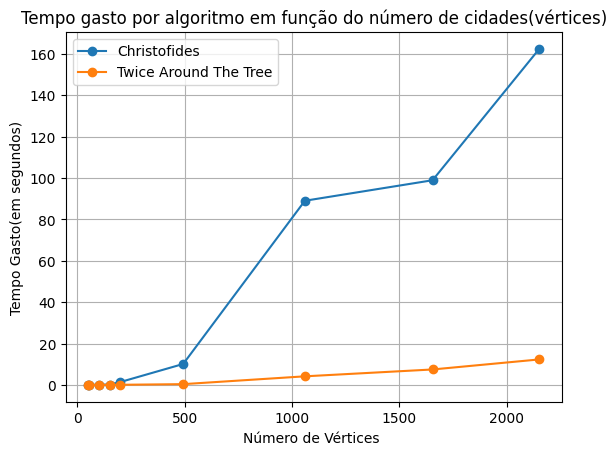

In [34]:
def plot_grafico(dicionario1, dicionario2):
    chaves1 = list(dicionario1.keys())
    valores1 = list(dicionario1.values())

    chaves2 = list(dicionario2.keys())
    valores2 = list(dicionario2.values())

    plt.plot(chaves1, valores1, marker='o', label='Christofides')
    plt.plot(chaves2, valores2, marker='o', label='Twice Around The Tree')

    plt.xlabel('Número de Vértices ')
    plt.ylabel('Tempo Gasto(em segundos)')
    plt.title('Tempo gasto por algoritmo em função do número de cidades(vértices)')
    plt.legend() 
    plt.grid(True)
    plt.show()

plot_grafico(christofides, TAT)

In [35]:
solucoes_otimas = {
    51: 426,
    52: 7542,
    100: 21282,
    150: 6528,
    200: 29368,
    493: 35002,
    1655: 62128,
    2152: 64253
}

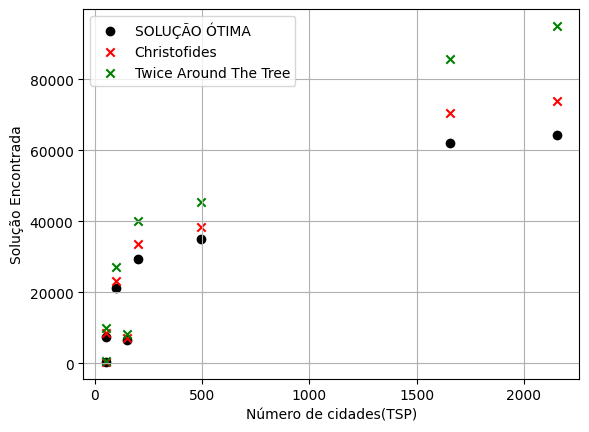

In [36]:
import matplotlib.pyplot as plt

def plot_scatter(dicionario1, dicionario2, dicionario3):
    chaves1 = list(dicionario1.keys())
    valores1 = list(dicionario1.values())

    chaves2 = list(dicionario2.keys())
    valores2 = list(dicionario2.values())

    chaves3 = list(dicionario3.keys())
    valores3 = list(dicionario3.values())    

    plt.scatter(chaves1, valores1, label='SOLUÇÃO ÓTIMA', marker='o', color='black')
    plt.scatter(chaves2, valores2, label='Christofides', marker='x', color='red')
    plt.scatter(chaves3, valores3, label='Twice Around The Tree', marker='x', color='green')


    plt.xlabel('Número de cidades(TSP)')
    plt.ylabel('Solução Encontrada')
    plt.legend()
    plt.grid(True)
    plt.show()

christofides2.pop(1060)
TAT2.pop(1060)


plot_scatter(solucoes_otimas, christofides2,TAT2)


In [ ]:
def calcula_desvio_medio_percentual(dic_otimo, dic_aproximado):
    if len(dic_otimo) != len(dic_aproximado):
        raise ValueError("Os dicionários devem ter o mesmo número de elementos")

    n = len(dic_otimo)
    desvios_percentuais = [abs((dic_otimo[chave] - dic_aproximado[chave]) / dic_otimo[chave]) * 100 for chave in dic_otimo]
    
    desvio_medio_percentual = sum(desvios_percentuais) / n
    return desvio_medio_percentual


desvio_medio = calcula_desvio_medio_percentual(solucoes_otimas, christofides2)
print(f"Desvio médio Christofides: {desvio_medio}")

desvio_medio = calcula_desvio_medio_percentual(solucoes_otimas, TAT2)
print(f"Desvio médio TAT: {desvio_medio}")


Desvio médio Christofides: 12.2756413086538
Desvio médio TAT: 36.36027895042995
